# Diffusion models for ultrasound image generation

In [5]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import keras
from usbmd import log
from usbmd.models.diffusion import DiffusionModel
from usbmd.ops import Pipeline, ScanConvert
from usbmd.visualize import plot_image_grid, set_mpl_style


In [2]:
presets = list(DiffusionModel.presets.keys())
log.info(f"Available built-in usbmd presets for DiffusionModel: {presets}")

model = DiffusionModel.from_preset("diffusion-echonet-dynamic")

## Prior sampling
prior_samples = model.sample(n_samples=16, n_steps=90, verbose=True)

usbmd: Available built-in usbmd presets for DiffusionModel: ['diffusion-echonet-dynamic']
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step


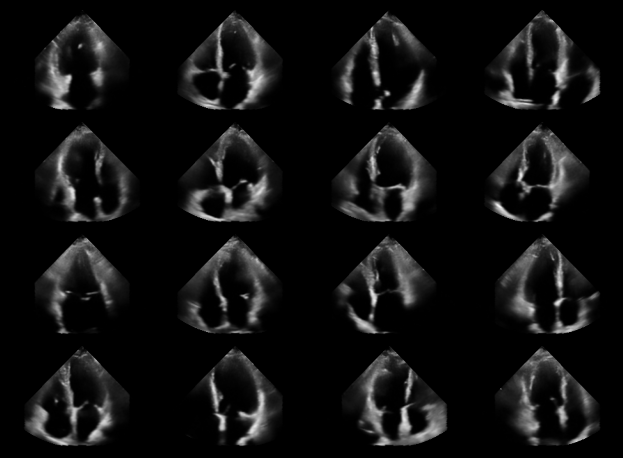

In [6]:

pipeline = Pipeline([ScanConvert(order=1, jit_compile=False)])
parameters = {
    "theta_range": [-0.78, 0.78],  # [-45, 45] in radians
    "rho_range": [0, 1],
}
prior_samples = keras.ops.squeeze(prior_samples, axis=-1)

parameters = pipeline.prepare_parameters(**parameters)
processed_batch = pipeline(data=prior_samples, **parameters)["data"]

## Plotting
set_mpl_style()
fig, _ = plot_image_grid(
    processed_batch, vmin=-1, vmax=1,
)